# Creating Weather Types

In this notebook we will start by computing weather types.
Then, we will look at composite anomalies and sequences of weather types that result from the calculation.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from paraguayfloodspy.weather_type import XrEofCluster
from paraguayfloodspy.pars import GetPars

In [2]:
%matplotlib inline

Load in the raw data -- in this case the streamfunction.
Note that it is *important* that you don't use anomalies taken against monthly climatology for the weather typing.
Otherwise, it would be possible (for example) to get a different weather type on December 31 and Jan 1st, even if the circulation was identical, because the corresponding climatologies were different.
Instead, subtract the mean after loading the data in

In [3]:
pars = GetPars('all')
ds = xr.open_dataset("../_data/reanalysis/subset/streamfunc_850_raw.nc")
ds = ds.sel(lat = slice(pars['wt_rgn']['latmax'], pars['wt_rgn']['latmin']), 
            lon = slice(pars['wt_rgn']['lonmin'], pars['wt_rgn']['lonmax']), 
            time = slice('{}-11-01'.format(pars['time']['syear']), '{}-02-29'.format(pars['time']['eyear'])))
ds = ds.sel(time = np.in1d(ds['time.month'], [11, 12, 1, 2]))
ds = ds - ds.mean(dim = 'time')

## How Many Weather Types?

The weather typing algorithm is performed using the `XrEofCluster` algorithm.
Our first step is to explore several reasonable values for the number of weather types and then to explore the Classifiability Index associated with each.

In [4]:
n_clusters = np.arange(2,10)
class_index = np.zeros(n_clusters.shape)
for i,nc in enumerate(n_clusters):
    _, _, ci = XrEofCluster(
        ds, 
        n_clusters=nc, # How many weather types to create?
        prop=0.95, # What proportion of variance should be retained?
        nsim=100, # How many random initializations to compute?
        variable='streamfunction',
        verbose = False # get useful info from the algorithm
    )
    class_index[i] = ci

/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:413: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})
/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:178: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4


Let's see how these possibilities compare:

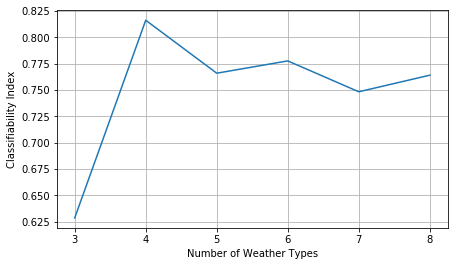

In [5]:
plt.figure(figsize=(7, 4))
plt.plot(n_clusters, class_index)
plt.xlabel("Number of Weather Types")
plt.ylabel("Classifiability Index")
plt.grid()

So, while 50 simulations is obviously less than ideal to see what the optimal classifiability index is, we see that anything in the range 4-7 is reasonable.
Although 4 provides the most stable estimates of the weather types, we choose $k=6$ because of the interpretability of the resulting weather types; this is a somewhat subjective choice but we feel a reasonable one.

## Weather Typing

Now we calculate the sequences of weather types

In [6]:
best_centroid, best_ts, classifiability = XrEofCluster(
    ds, 
    n_clusters=6, # How many weather types to create?
    prop=0.95, # What proportion of variance should be retained?
    nsim=250, # How many random initializations to compute?
    variable='streamfunction',
    verbose = True # get useful info from the algorithm
)

xarray-based classifiability for 6 clusters
Performing EOF decomposition of data for dimension reduction...
Number of EOFs retained is 4
Carrying out 250 k-means simulations...


/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:413: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})
/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:178: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


Computing classifiability index for each pair of simulations...


What is our Classifiability Index?

In [7]:
print("Classifiability Index: {}".format(classifiability))

Classifiability Index: 0.7686919803027027


Now get the data in a useful format

In [8]:
df = pd.DataFrame({'wtype': pd.Series(np.int_(best_ts), index=ds.time)})
df.head()

,wtype
time,
1979-11-01,1
1979-11-02,3
1979-11-03,6
1979-11-04,2
1979-11-05,2


Save to file

In [9]:
df.to_csv("../_data/derived/WeatherTypes.csv")